In [1]:
import os
import pandas as pd

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf



from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras

In [2]:
# project specific
from utils import data_handler
from utils.models import cnn_encoder

In [3]:
x_train, filenames = data_handler.generate_dataset(feature_selection_threshold = 5, retain_phases="2", return_filenames= True)
#x_train, filenames = data_handler.generate_dataset(feature_selection_threshold = 0, retain_phases="2", return_filenames= True)

retained phase 2
loading samples...
loaded 5740 samples
number of genes selected :  6161


In [4]:
latent_dim = 64
t_shape = (6161)
print(t_shape)

autoencoder = cnn_encoder.generate_model(t_shape, latent_dim)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

6161


In [5]:
hist = autoencoder.fit(x_train, epochs=100, shuffle=False)

Epoch 1/100


2023-07-18 11:43:11.946131: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


45/45 [==============================] - 9s 178ms/step - loss: 1424453.2853
Epoch 2/100
45/45 [==============================] - 8s 169ms/step - loss: 1008318.8832
Epoch 3/100
45/45 [==============================] - 8s 177ms/step - loss: 1000233.1508
Epoch 4/100
45/45 [==============================] - 7s 156ms/step - loss: 997495.3410
Epoch 5/100
45/45 [==============================] - 8s 172ms/step - loss: 995297.4986
Epoch 6/100
45/45 [==============================] - 7s 159ms/step - loss: 993841.1399
Epoch 7/100
45/45 [==============================] - 7s 163ms/step - loss: 992196.6590
Epoch 8/100
45/45 [==============================] - 7s 165ms/step - loss: 990469.4810
Epoch 9/100
45/45 [==============================] - 8s 166ms/step - loss: 988010.8641
Epoch 10/100
45/45 [==============================] - 8s 168ms/step - loss: 984022.2351
Epoch 11/100
45/45 [==============================] - 9s 192ms/step - loss: 975931.8465
Epoch 12/100
45/45 [==============================

In [6]:
e = iter(x_train).next()
e


<tf.Tensor: shape=(64, 6161), dtype=float32, numpy=
array([[  28.0786,   48.2889,   31.8768, ...,   21.601 ,   14.5302,
          43.2891],
       [  34.8483,   55.0274,   36.8456, ...,   28.7308,   33.4212,
          42.899 ],
       [  31.6444,   57.4141,   41.5785, ...,   37.2859,   22.7498,
          95.4406],
       ...,
       [  29.2446,   57.8746,   54.0729, ...,   83.0774,   39.6068,
         172.727 ],
       [  42.2485,   58.0206,   36.2277, ...,   65.3682,   19.7801,
         115.36  ],
       [1085.74  ,   54.7478,   37.7932, ...,   68.5695,   75.1809,
         106.025 ]], dtype=float32)>

In [7]:
z = autoencoder.encoder(e)
z

<tf.Tensor: shape=(64, 64), dtype=float32, numpy=
array([[0.0000000e+00, 1.1011568e+00, 8.5003336e-24, ..., 5.6258583e-33,
        6.5438644e+01, 0.0000000e+00],
       [0.0000000e+00, 8.4733200e+01, 1.3865252e-31, ..., 0.0000000e+00,
        5.2268614e-14, 0.0000000e+00],
       [0.0000000e+00, 1.2151521e+01, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 2.0064553e-29],
       ...,
       [5.5866787e-33, 5.3734863e+01, 4.0491797e-14, ..., 1.0285117e-18,
        5.3045254e+01, 3.3808381e-09],
       [1.8548418e-27, 6.9199547e+01, 6.2420300e-17, ..., 0.0000000e+00,
        9.0398363e-15, 0.0000000e+00],
       [0.0000000e+00, 1.0115930e+02, 3.0693047e-25, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)>

In [8]:
print(autoencoder.decoder(z))

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(64, 6161), dtype=float32)


[1211144.25, 953198.9375, 947479.1875, 944472.125, 942645.8125, 941247.9375, 939634.625, 937941.375, 935496.4375, 931348.8125, 922590.0, 900563.5625, 810327.25, 599375.5, 431813.4375, 368441.03125, 344347.34375, 327300.96875, 312775.75, 299397.59375, 287079.25, 275383.90625, 264819.1875, 254250.265625, 245210.484375, 234768.5, 226493.59375, 217281.296875, 209283.59375, 200440.78125, 191563.0, 183957.09375, 175832.15625, 168411.484375, 162510.828125, 155873.0625, 151417.6875, 148366.96875, 140269.578125, 137202.546875, 129433.953125, 126925.5546875, 121771.6953125, 115509.8671875, 115700.6640625, 111652.59375, 109948.296875, 107036.890625, 101962.2265625, 104581.0390625, 101914.625, 104946.609375, 117725.9609375, 125370.796875, 120136.1171875, 106526.46875, 106307.5234375, 115286.7109375, 97679.765625, 89668.2265625, 83832.265625, 82118.078125, 80811.9609375, 81761.6875, 82192.5546875, 86940.7265625, 85472.2890625, 86399.7109375, 96263.8046875, 99726.125, 98678.734375, 98077.03125, 8942

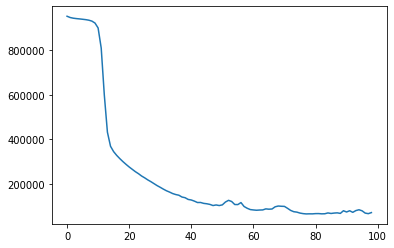

In [9]:
plt.plot(hist.history['loss'][1:])
print(hist.history['loss'])


In [8]:
autoencoder.encoder.save('../workfiles/cnn_autoencoer_model')


INFO:tensorflow:Assets written to: ../workfiles/cnn_autoencoer_model/assets


INFO:tensorflow:Assets written to: ../workfiles/cnn_autoencoer_model/assets


In [9]:
compressed_dataframe = autoencoder.encoder.predict(x_train)

45/45 [==============================] - 1s 26ms/step


In [10]:
df = pd.DataFrame(compressed_dataframe)
df["name"] = filenames

In [11]:
df.to_csv("../workfiles/compressed_data_cnn_autoencoder_phase_2.csv")
